### Import libraries

In [1]:
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Import model and simulate the medium

In [2]:
#Simulating the medium
iML1515 = read_sbml_model('Models/iML1515.xml') 
iML1515.medium


{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [3]:
# Create empty lists to store the...:
carbon = []
carbon_names = []

# Create a loop where we find all reactions that contains carbon:
for reaction in iML1515.exchanges:
    for metabolite in reaction.reactants:
        if "C" in metabolite.elements:
            carbon.append(reaction.id)
            carbon_names.append(reaction.name) 

#temporary change to the model
with iML1515:
    max_base_growth = iML1515.slim_optimize()
    iML1515.objective = iML1515.reactions.EX_asp__L_e
    max_base_production = iML1515.slim_optimize()
            

In [4]:
# Define lists we will be using:
max_growth = []
max_production = []
medium=iML1515.medium

In [5]:
 #Create loop for temporary changes in our model:
with iML1515:
    for reaction in carbon:
        medium['EX_glc__D_e'] = 0 # glucose in the medium
        medium[reaction]=1
        iML1515.medium = medium
        with iML1515:
            max_growth.append(iML1515.slim_optimize(error_value=0.))
            iML1515.objective = iML1515.reactions.EX_asp__L_e # production of l-aspartate
            max_production.append(iML1515.slim_optimize(error_value=0.))  # Determining max production
        medium[reaction]=0     

In [6]:
# Now, we collect all of the data in a dataframe:
production = {'Carbon': carbon_names,
             'Growth': max_growth,
             'Production': max_production}
df = pd.DataFrame(production, columns = ['Carbon', 'Growth', 'Production'])
print(df)

                                     Carbon    Growth  Production
0                              CO2 exchange  0.000000    0.000000
1                     L-Methionine exchange  0.000000    0.000000
2             L-Methionine S-oxide exchange  0.000000    0.000000
3           N-Acetyl-D-glucosamine exchange  0.089370    1.837241
4                       Cellobiose exchange  0.154755    3.000000
..                                      ...       ...         ...
286       4-aminobenzoyl-glutamate exchange  0.000000    0.000000
287                       Rifampin exchange  0.000000    0.000000
288  1-O-methyl-Beta-D-glucuronate exchange  0.046712    0.991020
289                        Quinate exchange  0.000000    0.000000
290            3-Hydroxypropanoate exchange  0.000000    0.000000

[291 rows x 3 columns]


In [7]:
# Create dataframe:
df= df[df['Growth'] != 0]
print(df)

                                     Carbon    Growth  Production
3           N-Acetyl-D-glucosamine exchange  0.089370    1.837241
4                       Cellobiose exchange  0.154755    3.000000
6                     Hypoxanthine exchange  0.005009    0.111209
9                        L-Lactate exchange  0.011857    0.256327
11                     D-Gluconate exchange  0.055878    1.181497
..                                      ...       ...         ...
270          L-alanine-D-glutamate exchange  0.080334    1.755636
272          L-alanine-L-glutamate exchange  0.080334    1.755636
276                     D-Xylonate exchange  0.036085    0.775686
285                Sulphoquinovose exchange  0.012082    0.256327
288  1-O-methyl-Beta-D-glucuronate exchange  0.046712    0.991020

[176 rows x 3 columns]


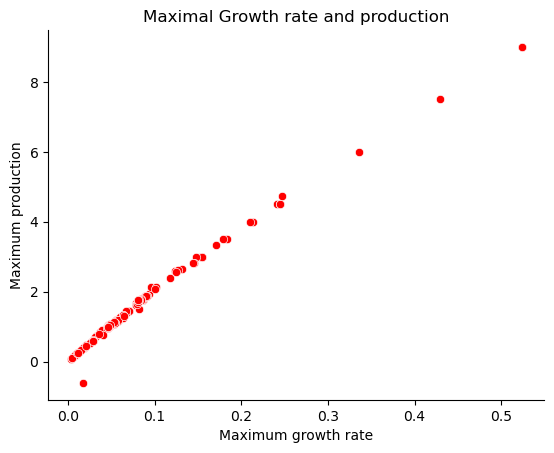

In [8]:
import seaborn as sns

# We create a scatterplot of the production over growth to view the distribution
sns.scatterplot(data=df, x='Growth', y='Production', color='red')
sns.despine()

plt.xlabel('Maximum growth rate')
plt.ylabel('Maximum production')
#plt.xlim(0, 0.9)
#plt.ylim(0, 0.5)
plt.title('Maximal Growth rate and production')
#plt.savefig("figures/carbon_sources")
plt.show()

In [9]:
# We write a new model with glucose as the carbon source
medium=iML1515.medium
medium['EX_glc__D_e'] = 10
iML1515.medium = medium
write_sbml_model(iML1515, "Models/iML1515_modified_glucose.xml") # creates a new file
iML1515_glucose = read_sbml_model('Models/iML1515_modified_glucose.xml') # set model to new file
iML1515_glucose.medium 

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [10]:
#set the optimal value for biomass to 100%
iML1515_glucose.reactions.BIOMASS_Ec_iML1515_core_75p37M.upper_bound=0.87699721425716
#set the lower bound to not be less than 75 % of the optimal value
iML1515_glucose.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound=0.87699721425716*0.75
#print the new objective value
iML1515_glucose_BM_optimized = print(iML1515.optimize().objective_value)

0.8769972144270309


In [11]:
# Claculate the max. theoretical yield for production of l-aspartate on glucose
with iML1515_glucose:
    iML1515_glucose.objective = iML1515_glucose.reactions.EX_asp__L_e
    Asp_production_1 = iML1515_glucose.optimize().objective_value
    max_yield_glucose = Asp_production_1/ (-1*iML1515_glucose.reactions.EX_glc__D_e.flux)
    #set the optimal value for biomass to 100%
print("Max. l-aspartate production [mmol gDW^-1 h^-1]:", Asp_production_1)
print("Theoretical max. yield [mmol-asp / mmol-glucose]:", max_yield_glucose)

Max. l-aspartate production [mmol gDW^-1 h^-1]: 4.548604209060673
Theoretical max. yield [mmol-asp / mmol-glucose]: 0.45486042090606726


In [12]:
#In cmol/cmol
CV_Asp = 4
CV_glc = 6
Asp_glucose_production_cmol = (max_yield_glucose*CV_Asp)/(1*CV_glc)
print('Maximum theoretical yield of L-aspartate=', Asp_glucose_production_cmol, 'cmol-Asp/cmol-glc')

Maximum theoretical yield of L-aspartate= 0.30324028060404484 cmol-Asp/cmol-glc


In [13]:
# Let's check the top 20 carbon sources that result in the highest growth
df.sort_values(by='Growth', ascending=False).head(20)

,Carbon,Growth,Production
190,Maltohexaose exchange,0.523400,9.000000
215,"1,4-alpha-D-glucan exchange",0.523400,9.000000
77,Maltopentaose exchange,0.429358,7.500000
239,Maltotetraose exchange,0.335316,6.000000
268,N-Acetyl-D-glucosamine(anhydrous)N-Acetylmuram...,0.246752,4.750000
128,Maltotriose exchange,0.245036,4.500000
108,Octadecenoate (n-C18:1) exchange,0.244296,4.500000
101,Octadecanoate (n-C18:0) exchange,0.240697,4.500000
65,Hexadecenoate (n-C16:1) exchange,0.213709,4.000000
171,Hexadecanoate (n-C16:0) exchange,0.210111,4.000000


In [14]:
# We have chosen 3 of interest, first we investigate maltohezaose
for reaction in iML1515.reactions.query('Maltohexaose exchange', 'name'):
    print(reaction.id)

EX_malthx_e


In [15]:
# Changing the carbon source to Maltohexaose:
medium=iML1515.medium
medium['EX_glc__D_e'] = 0
medium["EX_malthx_e"]= 10 # we set it to 10 as with glucose in the base medium
iML1515.medium = medium
write_sbml_model(iML1515, "Models/iML1515_modified_malthx.xml") # we create new file
iML1515_maltohexaose = read_sbml_model('Models/iML1515_modified_malthx.xml') # we set model to new file
iML1515_maltohexaose.medium 



{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_malthx_e': 10.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [16]:
# Claculate the maximum theoretical yield for production on Maltohexaose
with iML1515_maltohexaose:
    iML1515_maltohexaose.objective = iML1515_maltohexaose.reactions.EX_asp__L_e
    Asp_production_2 = iML1515_maltohexaose.optimize().objective_value
    max_yield_maltohexaose = Asp_production_2 / (-1*iML1515_maltohexaose.reactions.EX_malthx_e.flux)
    print("Max. l-aspartate production [mmol gDW^-1 h^-1]:", Asp_production_2)
    print("Max. theoretical yield [mmol-asp / mmol-maltohexaose]:", max_yield_maltohexaose) 

Max. l-aspartate production [mmol gDW^-1 h^-1]: 112.63034482758619
Max. theoretical yield [mmol-asp / mmol-maltohexaose]: 11.263034482758618


In [17]:
# Now we convert to Cmol/Cmol
CV_asp = 4 # Cmol/mol conversion factor for l asprtate
CV_malthx = 36 # Cmol/mol conversion factor for malthx

asp_malthx_production_cmol = (max_yield_maltohexaose*CV_asp)/(1*CV_malthx)
print('Maximum theoretical yield cmol/cmol=', asp_malthx_production_cmol, 'cmol-asp/cmol-malthx')

Maximum theoretical yield cmol/cmol= 1.2514482758620686 cmol-asp/cmol-malthx


In [18]:
# First we investigate  - we look for the ID of maltotriose exchange>
for reaction in iML1515.reactions.query('Maltotriose exchange', 'name'):
    print(reaction.id)

EX_malttr_e


In [19]:
# Changing the carbon source to maltotriose:
medium=iML1515.medium
medium['EX_glc__D_e'] = 0
medium["EX_malthx_e"]= 0
medium["EX_malttr_e"]= 10 # boundary set as for base medium with glucose
iML1515.medium = medium
write_sbml_model(iML1515, "Models/iML1515_modified_maltotriose.xml") 
iML1515_maltotriose = read_sbml_model('Models/iML1515_modified_maltotriose.xml')
iML1515_maltotriose.medium #

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_malttr_e': 10.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [20]:
# Claculate the max. theoretical yield for production on Maltohexaose
with iML1515_maltotriose:
    iML1515_maltotriose.objective = iML1515_maltotriose.reactions.EX_asp__L_e
    Asp_production_3 = iML1515_maltotriose.optimize().objective_value
    max_yield_maltotriose = Asp_production_3 / (-1*iML1515_maltotriose.reactions.EX_malttr_e.flux)
    print("Max. l-aspartate production [mmol gDW^-1 h^-1]:", Asp_production_3)
    print("Theoretical max. yield [mmol-asp / mmol-maltt]:", max_yield_maltotriose) 

Max. l-aspartate production [mmol gDW^-1 h^-1]: 55.388965517241346
Theoretical max. yield [mmol-asp / mmol-maltt]: 5.538896551724134


In [21]:
# Now we convert to Cmol/Cmol
CV_asp = 4 # Cmol/mol conversion factor for l aspartate
CV_maltotriose = 18 # Cmol/mol conversion factor for maltotriose

asp_maltotriose_production_cmol = (max_yield_maltotriose*CV_asp)/(1*CV_maltotriose)
print('Maximum theoretical yield cmol/cmol=', asp_maltotriose_production_cmol, 'cmol-asp/cmol-maltt')

Maximum theoretical yield cmol/cmol= 1.230865900383141 cmol-asp/cmol-maltt


In [22]:
#Now lets investigate maltose 
for reaction in iML1515.reactions.query('Maltose exchange', 'name'):
    print(reaction.id)
    

EX_malt_e


In [23]:
# Changing the carbon source to maltose:
medium=iML1515.medium
medium['EX_glc__D_e'] = 0
medium["EX_malthx_e"]= 0
medium["EX_malttr_e"]= 0
medium["EX_malt_e"]=10 # boundary set as for base medium with glucose
iML1515.medium = medium
write_sbml_model(iML1515, "Models/iML1515_modified_maltose.xml") 
iML1515_maltose = read_sbml_model('Models/iML1515_modified_maltose.xml')
iML1515_maltose.medium #

{'EX_pi_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_zn2_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_malt_e': 10.0,
 'EX_mobd_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_slnt_e': 1000.0}

In [24]:
# Max. theoretical yield for production on Maltose
with iML1515_maltose:
    iML1515_maltose.objective = iML1515_maltose.reactions.EX_asp__L_e
    Asp_production_4 = iML1515_maltose.optimize().objective_value
    max_yield_maltose = Asp_production_4 / (-1*iML1515_maltose.reactions.EX_malt_e.flux)
    print("Max. l-aspartate production [mmol gDW^-1 h^-1]:", Asp_production_4)
    print("Theoretical max. yield [mmol-asp / mmol-malt]:", max_yield_maltose) 

Max. l-aspartate production [mmol gDW^-1 h^-1]: 36.76827586206901
Theoretical max. yield [mmol-asp / mmol-malt]: 3.676827586206901


In [25]:
# Now we convert to Cmol/Cmol
CV_asp = 4 # Cmol/mol conversion factor for l aspartate
CV_maltose = 12 # Cmol/mol conversion factor for maltotriose

asp_maltose_production_cmol = (max_yield_maltose*CV_asp)/(1*CV_maltose)
print('Maximum theoretical yield cmol/cmol=', asp_maltose_production_cmol, 'cmol-asp/cmol-malt')

Maximum theoretical yield cmol/cmol= 1.2256091954023003 cmol-asp/cmol-malt


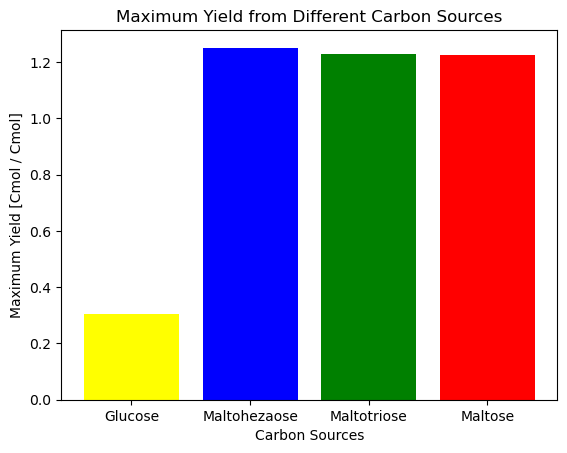

In [27]:
# Generate bar plot to visualize cmol/cmol

# Write values
yield_glucose_cmol = Asp_glucose_production_cmol
yield_maltohezaose_cmol = asp_malthx_production_cmol
yield_maltotriose_cmol = asp_maltotriose_production_cmol
yield_maltose_cmol = asp_maltose_production_cmol

# Carbon sources
carbon_sources_cmol = ['Glucose', 'Maltohezaose', 'Maltotriose', 'Maltose']

# Maximum yields
max_yields_cmol = [yield_glucose_cmol, yield_maltohezaose_cmol, yield_maltotriose_cmol, yield_maltose_cmol]

# Plotting
plt.bar(carbon_sources_cmol, max_yields_cmol, color=['yellow', 'blue', 'green', 'red'])
plt.xlabel('Carbon Sources')
plt.ylabel('Max. Yield [Cmol/Cmol]')
plt.title('Max. Yield using different carbon sources')
plt.show()